In [31]:
# Standard librariees
import numpy as np
import pandas as pd
from numpy.random import randn
from pandas import Series, DataFrame

#Statistics
from scipy import stats

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

Part 2. Download the data provided to you in .csv format. Check whether the data is cointegrated and apply appropriate regression technique. On top of that, using grangercausalitytests from statsmodels library check for granger causality. You will need to read this short intro to understand better Granger causality: http://www.scholarpedia.org/article/Granger_causality#Stationarity



In [32]:
# Libraries for time series analysis
import os
import sys


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as smtools
import scipy.stats as scs
from arch import arch_model

In [33]:
df = pd.read_csv("adsa.csv")

In [34]:
df.head()

,Year,Advertising,Sales
0,1907,608,1016
1,1908,451,921
2,1909,529,934
3,1910,543,976
4,1911,525,930


In [35]:
ts = pd.period_range(start='1/1/1907', end='1/1/1960', freq='A')
df['Date'] = ts
df.set_index('Date',inplace=True)

In [36]:
df.tail()

,Year,Advertising,Sales
Date,,,
1956,1956,802,1657
1957,1957,770,1569
1958,1958,639,1390
1959,1959,644,1387
1960,1960,564,1289


In [37]:
df=df.drop(['Year'], axis=1)

In [38]:
df.tail()

,Advertising,Sales
Date,,
1956,802,1657
1957,770,1569
1958,639,1390
1959,644,1387
1960,564,1289


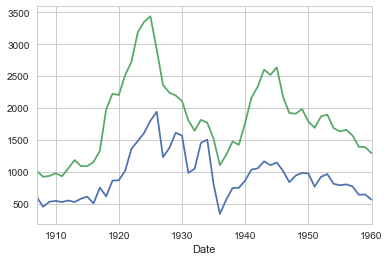

In [39]:
df['Advertising'].plot() 
df['Sales'].plot() 
plt.show()

In [40]:
smtools.coint(df['Sales'], df['Advertising'], trend='ct', method='aeg', maxlag=1, autolag='aic', return_results=None)
#0.41 indicates that we fail to reject the null hypothesis
#this means that there is no cointegration between the series.
#there is a spurious relationship between Sales and Advertising. 
#this can also be seen as the data are not stationary, but to be cointegrated they need to be stationary

(-2.6982238366694111,
 0.41167820805368094,
 array([-4.6316179 , -3.96431361, -3.63245968]))

In [41]:
from statsmodels.tsa.stattools import adfuller

In [42]:
result = adfuller(df['Sales'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -2.257078
p-value: 0.457821
Critical Values:
	5%: -3.499
	1%: -4.144
	10%: -3.178


In [43]:
result = adfuller(df['Advertising'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.302739
p-value: 0.432436
Critical Values:
	5%: -3.504
	1%: -4.157
	10%: -3.182


In [44]:
df["dSales"]=df['Sales'].diff(periods=1)
df["dAdvertising"]=df['Advertising'].diff(periods=1)
df.dropna(inplace=True)
df.head()

,Advertising,Sales,dSales,dAdvertising
Date,,,,
1908,451,921,-95.0,-157.0
1909,529,934,13.0,78.0
1910,543,976,42.0,14.0
1911,525,930,-46.0,-18.0
1912,549,1052,122.0,24.0


In [45]:
result = adfuller(df['dSales'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.599927
p-value: 0.001031
Critical Values:
	5%: -3.499
	1%: -4.144
	10%: -3.178


In [46]:
result = adfuller(df['dAdvertising'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.993967
p-value: 0.133776
Critical Values:
	5%: -3.504
	1%: -4.157
	10%: -3.182


In [47]:
df["ddAdvertising"]=df['dAdvertising'].diff(periods=1)
df.dropna(inplace=True)

In [48]:
result = adfuller(df['ddAdvertising'],regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.450771
p-value: 0.000000
Critical Values:
	5%: -3.504
	1%: -4.157
	10%: -3.182


In [49]:
smtools.coint(df['dSales'], df['ddAdvertising'], trend='ct', method='aeg', maxlag=1, autolag='aic', return_results=None)

(-3.860782337977736,
 0.040487255269665144,
 array([-4.64405702, -3.97169441, -3.63789602]))

In [50]:
#we can see that data is cointegrated as p<0.05

In [51]:
X_multi=df['ddAdvertising']
Y_target=df['dSales']
# Add the costant to our input variables
X_multi=sm.tools.tools.add_constant(X_multi, prepend=True, has_constant='skip')

In [52]:
# OLS Regression
mod = sm.OLS(Y_target, X_multi)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 dSales   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.671
Date:                Mon, 16 Apr 2018   Prob (F-statistic):             0.0611
Time:                        20:39:17   Log-Likelihood:                -355.82
No. Observations:                  52   AIC:                             715.6
Df Residuals:                      50   BIC:                             719.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.7776     32.063      0.211